In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import torch, pickle, sys
sys.path.append('/home/dgotzens/scripts/')
# setup
nfft = 2**10

pi = 3.141592653589 
maxdist = 50
lightspeed = 299_792_458 
f_start, f_end = 76_009_996_288.0, 80_289_505_280.0
t_chirp = 0.000_064_890_002_249_740_060
hertz_per_meter = (f_end-f_start) / t_chirp / lightspeed
bins_per_meter = nfft / maxdist


loaded data for 2m. processing...
loaded data for 8m. processing...
loaded data for 18m. processing...
loaded data for 32m. processing...
loaded data for 2m. processing...
loaded data for 8m. processing...
loaded data for 18m. processing...
loaded data for 32m. processing...


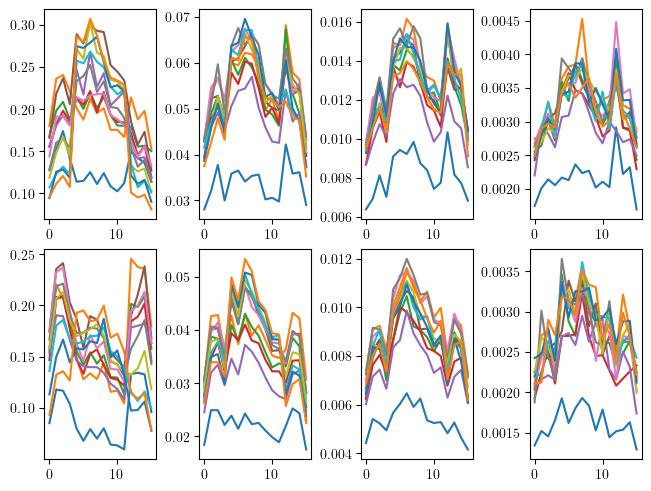

In [37]:
folder = '/home/dgotzens/recording/'

fig, ax = plt.subplots(2,4,layout="constrained")
Ntx,Nrx = 12,16
for m, measurement in enumerate(('a','d')):
    for n, dist in enumerate((2,8,18,32)):
        with open(f'{folder}{measurement}{dist:02d}_angle.pkl', 'rb') as f:
            angle = pickle.load(f)
        angle_deg = [round(a*180/pi-90) for a in angle]
        l_deg = [angle_deg.index(a) for a in sorted(set(angle_deg))]
        angle_deg = list(sorted(set(angle_deg)))
        data = torch.load(f'{folder}{measurement}{dist:02d}_data.pt')[:,:,l_deg]
        M,K,L = data.shape
        assert Ntx*Nrx==K

        print(f'loaded data for {dist}m. processing...')

        bp_start = int((dist-0.5)*bins_per_meter)
        bp_len = int(1*bins_per_meter)

        window = torch.hann_window(M)
        window = window / window.sum()

        gain = torch.empty(K,L)


        fft = torch.fft.fft(window[:,None,None]*data, n=nfft, dim=0)
        m_refl = fft[bp_start:bp_start+bp_len,:,:].abs().mean(1).argmax(0) + bp_start
        gain = fft.abs()[m_refl, :, range(L)].max(0).values
        for i in range(Ntx):
            ax[m,n].plot(20*gain.log10()[Nrx*i:Nrx*(i+1)])